# Quasi-dynamic MFD writeup

We can define two types of MFDs---a speed MFD $V(n)$ relating average speed to accumulation, and a production MFD $P(n)$ relating production (total vehicle miles traveled per unit time) to accumulation. These are related: by definition, we have $V(n(t)) = P(n(t)) / n(t)$.  In the updated formulation to be used in the GEMS model, we will assume that production is always proportional to outflow---that the rate of vehicles leaving the network at any given point of time relates only to the production on the network: $O(n) = \frac{P(n)}{L}$. This is known as an accumulation-based MFD, as opposed to a trip-based MFD. From Mariotte et al.: *Macroscopic urban dynamics: Analytical and numerical comparisons of existing models*:

> ... this paper made a large comparison between the trip-based model and the accumulation-based one, which is still widely used for the development of more complex applications like multi-reservoir simulation and dynamic control. Our literature review allows to draw a synthesis about the hypothesis history of both approaches. Their differences are then clearly stated: unlike the trip-based model the accumulation-based one (i) mostly ignores traveled distances, (ii) has no memory of the past of the system, and (iii) considers that accumulation remains constant when a user travels in the reservoir. These assumptions are responsible for the incoherence in the model results during transient phases: drop in travel time when the demand increases and slow response of the system in fast-varying conditions are notably observed. In steady state however, the two models give the same results. Regarding the travel time drop phenomenon, we have then proposed a validity domain of the accumulation-based model with respect to the demand variation rate.

The Mariotte paper makes the point that this simple accumulation based representation can lead to some unexpected and unrealistic system behavior around sharp changes in demand, including congestion propogating across zones faster than is physically possible, or travel times decreasing in anticipation of changes in demand. However, in our simplified macroscopic model we contend that the simpler accumulation-based framework is sufficient.

While the Mariotte paper defines a production MFD, here we use a simpler speed MFD that allows for fewer parameters to be used. First we can define a quadratic speed MFD with freeflow speed $V_0$ and jam accumulation $N_0$:

\\[v(t) = V_0 \left(1 - \frac{N(t)}{N_0} \right) \\]


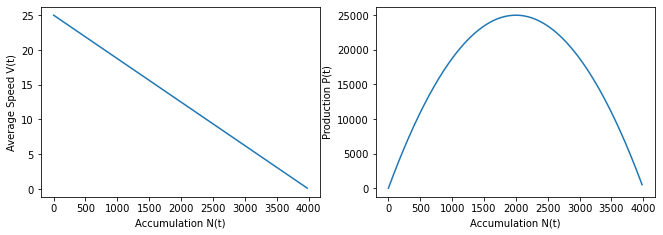

In [2]:
import numpy as np
import matplotlib.pyplot as plt

def v(n):
    return np.min([np.max([v_0*(1 - n / n_0), 0]), v_0])

def outflow(n):
    return v(n) * n / L

def dn_dt(n, demand):
    return demand - outflow(n)

v_0 = 25
n_0 = 4000
L = 5

Ns = np.arange(0,n_0,20.0)
Vs = np.zeros_like(Ns)
Ps = np.zeros_like(Ns)

for i, n in enumerate(Ns):
    Vs[i] = v(n)
    Ps[i] = v(n) * n

plt.subplot(121)
plt.plot(Ns, Vs)
plt.xlabel('Accumulation N(t)')
plt.ylabel('Average Speed V(t)')

plt.subplot(122)
plt.plot(Ns, Ps)
plt.xlabel('Accumulation N(t)')
plt.ylabel('Production P(t)')

fig = plt.gcf()
fig.set_size_inches(11,3.5)

Because the MFD is so simple, we can solve backwards for the steady state accumulation. Given the rate of vehicles entering the network, $\lambda$, and trip average distance $L$, we can determine the average accumulation using Little's law:

\\[ N_{\infty} = \frac{\lambda L }{ V_{\infty}} = \frac{\lambda L }{ V_0 \left(1 - \frac{N_{\infty}}{N_0} \right)}\\]

Solving gives:

\\[N_{\infty} = \frac{N_0 \left(V_0 \pm \sqrt{V_0^2 - 4 \lambda * L V_0 / N_0}\right) } { 2 \, V_0} \\]


This leads to two possible steady state accumulations, an uncongested (smaller) accumulation and a congested (larger) accumulation.

In [3]:
def n_ss(demand):
    return 0.5 * n_0 / v_0 * (v_0 - np.sqrt(v_0 ** 2 - 4 * demand * L * v_0 / n_0))

def n_ss_c(demand):
    return 0.5 * n_0 / v_0 * (v_0 + np.sqrt(v_0 ** 2 - 4 * demand * L * v_0 / n_0))

This means that any level of demand can be either associated with two possible steady state solutions (although the higher-accumulation steady state is an unsteady equilibrium), or zero steady state solutions (if demand is too high). Thus, in the initial version of the GEMS model, the uncongested speed and accumulation was determined from the demand for travel in each microtype and used to determine user costs. This steady state accumulation and speed can be plotted as a function of demand. In the initial GEMS model, if demand was higher than a microtype's maximum demand, 

<ipython-input-3-f65068ffaf7a>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.5 * n_0 / v_0 * (v_0 - np.sqrt(v_0 ** 2 - 4 * demand * L * v_0 / n_0))
<ipython-input-3-f65068ffaf7a>:5: RuntimeWarning: invalid value encountered in sqrt
  return 0.5 * n_0 / v_0 * (v_0 + np.sqrt(v_0 ** 2 - 4 * demand * L * v_0 / n_0))


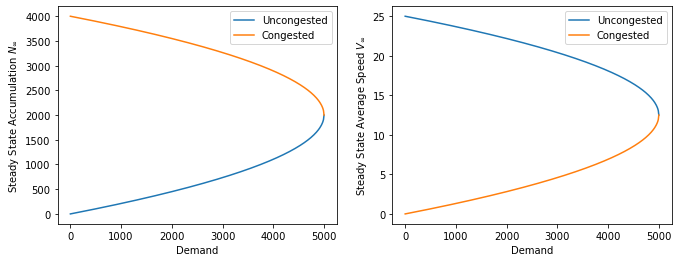

In [4]:


demands = np.arange(0,6000,10, dtype=float)
N = np.zeros_like(demands)
N_c = np.zeros_like(demands)
V = np.zeros_like(demands)
V_c = np.zeros_like(demands)
for i, d in enumerate(demands):
    N[i] = n_ss(d)
    N_c[i] = n_ss_c(d)
    V[i] = v(N[i])
    V_c[i] = v(N_c[i])

plt.subplot(121)
plt.plot(demands, N,label="Uncongested")
plt.plot(demands, N_c,label="Congested")
plt.legend()
plt.xlabel('Demand')
plt.ylabel('Steady State Accumulation $N_{\infty}$')

plt.subplot(122)

plt.plot(demands, V,label="Uncongested")
plt.plot(demands, V_c,label="Congested")
plt.legend()
plt.xlabel('Demand')
plt.ylabel('Steady State Average Speed $V_{\infty}$')

fig = plt.gcf()
fig.set_size_inches(11,4)

Integrating this differential equation in time allows us to plot the evolution of accumulation and speed over time as a function of initial conditions and demand.



 We can plug into the "mass balance" equation to solve for the instantaneous rate of change of the accumulation based on the current speed and accumulation:

\\[\frac{d N(t)}{dt} = \lambda(t) - \frac{v(N(t)) N(t)}{L} = \lambda(t) - \frac{ V_0 \left(1 - \frac{N(t)}{N_0} \right) N(t)}{L} \\]

We can use this to integrate the differential equation numerically. For example we can define a simple toy day of travel where demand forms a morning and evening peak. Plotting accumulation over time shows the difference between the pseudo-dynamic version and the steady state version:

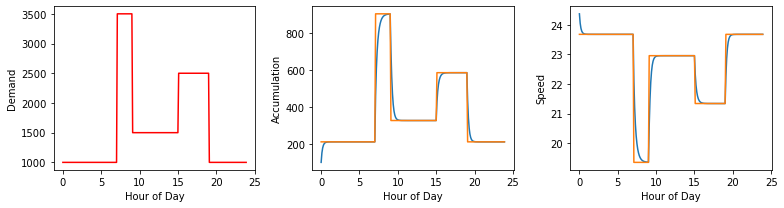

In [5]:
n_init = 0.0
dt = 0.1
t_f = 24

ts = np.arange(0, t_f, dt)
ns = np.zeros_like(ts)
nss = np.zeros_like(ts)
vs = np.zeros_like(ts)
vss = np.zeros_like(ts)
demands = np.zeros_like(ts)
demands[ts >= 0] = 1000.0
demands[ts > 7] = 3500
demands[ts > 9] = 1500.0
demands[ts > 15] = 2500
demands[ts > 19] = 1000.0


n = n_init
for i, t in enumerate(ts):
    dn = dn_dt(n, demands[i]) * dt
    n += dn
    ns[i] = n
    vs[i] = v(n)
    nss[i] = n_ss(demands[i])
    vss[i] = v(n_ss(demands[i]))
    
plt.subplot(131)
plt.plot(ts, demands, 'r-')
plt.xlabel("Hour of Day")
plt.ylabel("Demand")

plt.subplot(132)
plt.plot(ts, ns, label="Pseudo-dynamic")
plt.plot(ts, nss, label="Steady state")
plt.xlabel("Hour of Day")
plt.ylabel("Accumulation")

plt.subplot(133)
plt.plot(ts, vs, label="Pseudo-dynamic")
plt.plot(ts, vss, label="Steady state")
#plt.legend(title="MFD Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Hour of Day")
plt.ylabel("Speed")

fig = plt.gcf()
fig.set_size_inches(11,3)
plt.gcf().tight_layout()



We can also display the cumulative number of vehicles entering and exiting the system over time, although with these parameters the differences between the two lines (showing instantaneous accumulation) can be hard to see.

Text(0, 0.5, 'Number of vehicles')

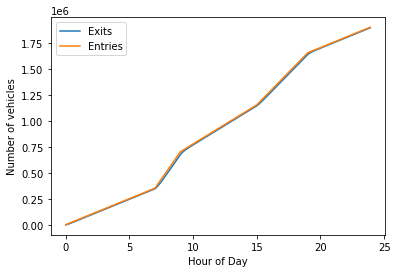

In [6]:
plt.plot(ts, np.cumsum(ns*vs), label="Exits")
plt.plot(ts, np.cumsum(demands)*L, label="Entries")
plt.legend()
plt.xlabel("Hour of Day")
plt.ylabel("Number of vehicles")

<ipython-input-3-f65068ffaf7a>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.5 * n_0 / v_0 * (v_0 - np.sqrt(v_0 ** 2 - 4 * demand * L * v_0 / n_0))


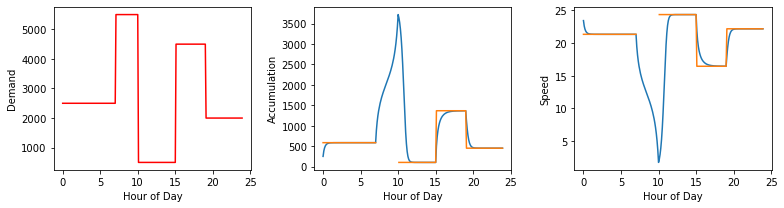

In [7]:
ts = np.arange(0, t_f, dt)
ns = np.zeros_like(ts)
nss = np.zeros_like(ts)
vs = np.zeros_like(ts)
vss = np.zeros_like(ts)
outflows = np.zeros_like(ts)
demands = np.zeros_like(ts)
demands[ts >= 0] = 2500.0
demands[ts > 7] = 5500
demands[ts > 10] = 500.0
demands[ts > 15] = 4500
demands[ts > 19] = 2000.0

n = n_init
for i, t in enumerate(ts):
    dn = dn_dt(n, demands[i]) * dt
    outflows[i] = v(n) * n / L
    n += dn
    ns[i] = n
    vs[i] = v(n)
    nss[i] = n_ss(demands[i])
    vss[i] = v(n_ss(demands[i]))
    
plt.subplot(131)
plt.plot(ts, demands, 'r-')
plt.xlabel("Hour of Day")
plt.ylabel("Demand")

plt.subplot(132)
plt.plot(ts, ns, label="Pseudo-dynamic")
plt.plot(ts, nss, label="Steady state")
plt.xlabel("Hour of Day")
plt.ylabel("Accumulation")

plt.subplot(133)
plt.plot(ts, vs, label="Pseudo-dynamic")
plt.plot(ts, vss, label="Steady state")
#plt.legend(title="MFD Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Hour of Day")
plt.ylabel("Speed")

fig = plt.gcf()
fig.set_size_inches(11,3)
plt.gcf().tight_layout()


The differential equation can be solved numerically (see http://educ.jmu.edu/~sochacjs/M341/TheQuadraticODE.pdf). Starting again with the differential equation governing accumulation over time:

\\[ \frac{d N(t)}{dt} = \lambda - \frac{ V_0 N(t)}{L} + \frac{N^2(t) V_0}{N_0 L}\\]

This equation can be factored:

\\[\frac{d N(t)}{dt} = \frac{V_0}{N_0 L}\left(N - \frac{N_0}{2} -  \sqrt{\frac{N_0^2}{4} - \frac{N_0 L_0 \lambda}{V_0}} \right) \left(N - \frac{N_0}{2} + \sqrt{\frac{N_0^2}{4} - \frac{N_0 L_0 \lambda}{V_0}} \right)\\]

If we define $A = \sqrt{\frac{N_0^2}{4} - \frac{N_0 L_0 \lambda}{V_0} }$ , we can rewrite the differential equation as

\\[\frac{d N(t)}{dt} = \frac{V_0}{N_0 L} \left( {N} - \frac{N_0}{2} - A \right)\left({N} - \frac{N_0}{2} + A \right).
\\]

The solution of this differential equation is

\\[N(t) = \frac{N_0}{2} - \frac{A}{\tanh \left(A \frac{V_0 t}{N_0 L} + C \right)}
\\]

The value of the constant $C$ depends on the initial accumulation of the system $N_t$ when $t=0$. Requiring this condition means that we can rewrite the differential equation as:

\\[N(t) = \frac{N_0}{2} - A \frac{\left(\frac{N_0}{2} - N_t \right) \cosh \left(\frac{A V_0}{N_0 L}t \right) + A \sinh \left(\frac{A V_0}{N_0 L}t \right)}{\left(\frac{N_0}{2} - N_t \right) \sinh \left(\frac{A V_0}{N_0 L}t \right) + A \cosh \left(\frac{A V_0}{N_0 L}t \right)}
\\]

This solution is valid across the range of possible inputs, but it involves complex numbers in cases where the demand of the system is greater than capacity. In this case, $A$ is imaginary because $\frac{N_0 L_0 \lambda}{V_0} > \frac{N_0^2}{4}$. We can rewrite the equation in a way that does not involve taking functions of complex numbers by defining $\mathcal{A} = iA = \sqrt{\frac{N_0 L_0 \lambda}{V_0} - \frac{N_0^2}{4}}$. Substituting $A = (-i\mathcal{A})$ into the previous equation gives:

\\[N(t) = \frac{N_0}{2} - \mathcal{A} \frac{\left(\frac{N_0}{2} - N_t \right) \cos \left(\frac{\mathcal{A} V_0}{N_0 L}t \right) - \mathcal{A} \sin \left(\frac{\mathcal{A} V_0}{N_0 L}t \right)}{\left(\frac{N_0}{2} - N_t \right) \sin \left(\frac{\mathcal{A} V_0}{N_0 L}t \right) + \mathcal{A} \cos \left(\frac{\mathcal{A} V_0}{N_0 L}t \right)}
\\]

This equivalent way of expressing the time behavior of the system is always real when demand exceeds capacity. These two equivalent formulations can be used to describe the time behavior of the MFD over any time period as long as demand is fixed. The situations are:

1. Accumulation approaches the stable steady-state from below, with demand below capacity
2. Accumulation approaches the stable steady-state from above, with demand below capacity
3. Accumulation starts above the unstable steady-state and increases towards infinity, with demand below capacity
4. Accumulation increases towards infinity, with demand above capacity

The four are plotted below, comparing the analytical solution with the numerical approximation.

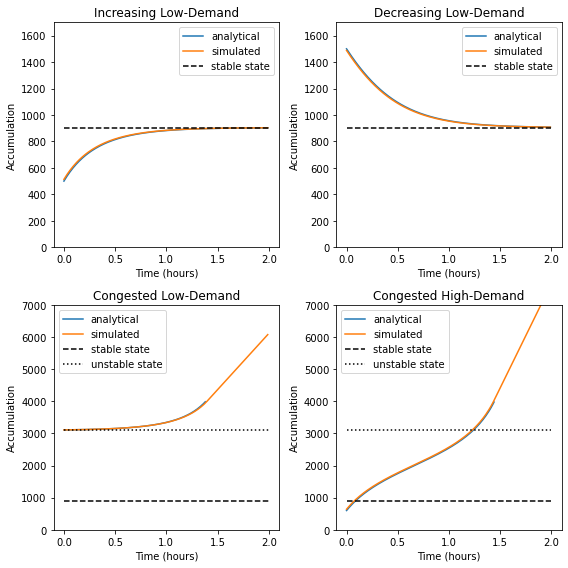

In [55]:
v_0 = 25
n_0 = 4000
L = 5

def getN(demand, t, n_t):
    if n_0**2./4. > demand * L * n_0 / v_0:
        A = np.sqrt(n_0**2./4. - demand * L * n_0 / v_0)
        N = N_tanh(t, n_t, A)
    else:
        A_cal = np.sqrt(demand * L * n_0 / v_0 - n_0**2./4.)
        N = N_tan(t, n_t, A_cal)
    if (N > 0) & (N <= n_0):
        return N
    else:
        return np.nan

def N_tan(t, n_t, A):
    N = n_0/2.0 - A * ((n_0/2. -n_t)*np.cos(A*v_0*t/(L*n_0)) - A*np.sin(A*v_0*t/(L*n_0))) / ((n_0/2. -n_t)*np.sin(A*v_0*t/(L*n_0)) + A*np.cos(A*v_0*t/(L*n_0)))
    return N

def N_tanh(t, n_t, A):
    N = n_0/2.0 - A * ((n_0/2. -n_t)*np.cosh(A*v_0*t/(L*n_0)) + A*np.sinh(A*v_0*t/(L*n_0))) / ((n_0/2. -n_t)*np.sinh(A*v_0*t/(L*n_0)) + A*np.cosh(A*v_0*t/(L*n_0)))
    return N


dt = 0.01
ts = np.arange(0, 2, dt)
N_a = np.zeros_like(ts)
N_c = np.zeros_like(ts)
dndt_1 = np.zeros_like(ts)
dndt_2 = np.zeros_like(ts)

demand = 3500
n_init = 500

stable = n_0 / 2 - np.sqrt(n_0**2./4. - demand * L * n_0 / v_0)
unstable = n_0 / 2 + np.sqrt(n_0**2./4. - demand * L * n_0 / v_0)

n = n_init
for ind, t in enumerate(ts):
    N_a[ind] = getN(demand,t, n_init)
    dn = dn_dt(n , demand) * dt
    n += dn
    N_c[ind] = n
    
plt.subplot(221)
plt.plot(ts, N_a, label="analytical")
plt.plot(ts, N_c, label="simulated")
plt.plot([0,2],[stable,stable],'k--',label='stable state')
plt.ylim((0,1700))
plt.xlabel('Time (hours)')
plt.ylabel('Accumulation')
plt.title('Increasing Low-Demand')
plt.legend()

demand = 3500
n_init = 1500
n = n_init
for ind, t in enumerate(ts):
    N_a[ind] = getN(demand,t, n_init)
    dn = dn_dt(n , demand) * dt
    n += dn
    N_c[ind] = n
    
plt.subplot(222)
plt.plot(ts, N_a, label="analytical")
plt.plot(ts, N_c, label="simulated")
plt.plot([0,2],[stable,stable],'k--',label='stable state')
plt.ylim((0,1700))
plt.xlabel('Time (hours)')
plt.ylabel('Accumulation')
plt.title('Decreasing Low-Demand')
plt.legend()

demand = 3500
n_init = 3110
n = n_init
for ind, t in enumerate(ts):
    N_a[ind] = getN(demand,t, n_init)
    dn = dn_dt(n , demand) * dt
    n += dn
    N_c[ind] = n

plt.subplot(223)
plt.plot(ts, N_a, label="analytical")
plt.plot(ts, N_c, label="simulated")
plt.plot([0,2],[stable,stable],'k--',label='stable state')
plt.plot([0,2],[unstable,unstable],'k:',label='unstable state')
plt.ylim((0,7000))
plt.xlabel('Time (hours)')
plt.ylabel('Accumulation')
plt.title('Congested Low-Demand')
plt.legend()


demand = 6500
n_init = 600
n = n_init
for ind, t in enumerate(ts):
    N_a[ind] = getN(demand,t, n_init)
    dn = dn_dt(n , demand) * dt
    n += dn
    N_c[ind] = n

plt.subplot(224)
plt.plot(ts, N_a, label="analytical")
plt.plot(ts, N_c, label="simulated")
plt.plot([0,2],[stable,stable],'k--',label='stable state')
plt.plot([0,2],[unstable,unstable],'k:',label='unstable state')
plt.ylim((0,7000))
plt.xlabel('Time (hours)')
plt.ylabel('Accumulation')
plt.title('Congested High-Demand')
plt.legend()


fig = plt.gcf()
fig.set_size_inches(8,8)
plt.gcf().tight_layout()

Note that the two congested cases, the analytical line ends up eventually diverging from the simulated line. This is because the (hastily done) numerical integration can't keep up with how quickly the function is growing. At very high accumulations the analytical approximation breaks down anyway (accumulation can't actually reach infinity), so there should still be some way of catching situations where accumulation blows up to infinity and marking them as infeasible.

Using this equation, we can determine the accumulation at the end of a time period given the accumulation at the beginning of the time period and the (steady) demand over that time period. This then allows us to carry over congestion from one time period to the next, allowing for congestion spillover and brief periods where demand exceeds capacity.

We can also solve for the average speed over a time period of duration T:

\\[
-\frac{1}{4}\frac{8 A^2 L N_0 - 2 L N_0^3 + 8 L N_0^2 N_t - 8 L N_0 N_t^2 + (8 A^3 - 4 A^2 N_0 - 2 A N_0^2 + N_0^3 + 2 (4 A^2 - N_0^2) N_t) T V_0 - (8 A^2 L N_0 - 2 L N_0^3 + 8 L N_0^2 N_t - 8 L N_0 N_t^2 - (8 A^3 + 4 A^2 N_0 - 2 A N_0^2 - N_0^3 - 2 (4 A^2 - N_0^2) N_t) T V_0) e^{\frac{2ATV_0}{LN_0}}}{(2 A N_0 + N_0^2 - 2 N_0 N_t) e^{\frac{2ATV_0}{LN_0}} + 2 A N_0 - N_0^2 + 2 N_0 N_t}
\\]

This can presumably be simplified further, but it also allows us to calculate average user costs over the time period which can be fed back into the mode choice component of the model.

\\[
-\frac{1}{4}\frac{(8 A^2 L N_0 - 2 L N_0^3 + 8 L N_0^2 N_t - 8 L N_0 N_t^2- 4 A^2 N_0T V_0+ N_0^3 T V_0+ 2 (4 A^2 - N_0^2) N_t T V_0)(1+e^{\frac{2ATV_0}{LN_0}}) + (8 A^3  - 2 A N_0^2 ) T V_0 (1 - e^{\frac{2ATV_0}{LN_0}})}{(2 A N_0 + N_0^2 - 2 N_0 N_t) (1+e^{\frac{2ATV_0}{LN_0}}) }
\\]

\\[
-\frac{1}{4}\frac{(4 A^2 (2 L N_0 - N_0T V_0 + 2  N_t T V_0) + 2 L N_0 (4 N_t N_0  - N_0^2 - 4 N_t^2) + N_0^3 T V_0 - 2N_0^2 N_t T V_0)(1+e^{\frac{2ATV_0}{LN_0}}) + (8 A^3  - 2 A N_0^2 ) T V_0 (1 - e^{\frac{2ATV_0}{LN_0}})}{(2 A N_0 + N_0^2 - 2 N_0 N_t) (1+e^{\frac{2ATV_0}{LN_0}}) }
\\]

<ipython-input-3-f65068ffaf7a>:2: RuntimeWarning: invalid value encountered in sqrt
  return 0.5 * n_0 / v_0 * (v_0 - np.sqrt(v_0 ** 2 - 4 * demand * L * v_0 / n_0))


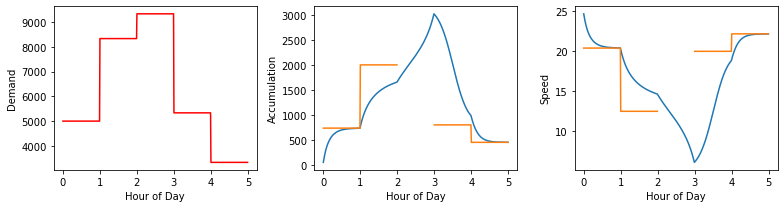

In [56]:
L = 3.
t_f = 5.
n_init=0.0

ts = np.arange(0, t_f, dt)
ns = np.zeros_like(ts)
nss = np.zeros_like(ts)
vs = np.zeros_like(ts)
vss = np.zeros_like(ts)
outflows = np.zeros_like(ts)

PMTs = np.zeros_like(ts)

PMTs[ts >= 0] = 15000.0
PMTs[ts >= 1] = 25000.0
PMTs[ts >= 2] = 28000.0
PMTs[ts >= 3] = 16000.0
PMTs[ts >= 4] = 10000.0

demands = PMTs / L

n = n_init
for i, t in enumerate(ts):
    dn = dn_dt(n, demands[i]) * dt
    n += dn
    ns[i] = n
    vs[i] = v(n)
    nss[i] = n_ss(demands[i])
    vss[i] = v(n_ss(demands[i]))
    
plt.subplot(131)
plt.plot(ts, demands, 'r-')
plt.xlabel("Hour of Day")
plt.ylabel("Demand")

plt.subplot(132)
plt.plot(ts, ns, label="Pseudo-dynamic")
plt.plot(ts, nss, label="Steady state")
plt.xlabel("Hour of Day")
plt.ylabel("Accumulation")

plt.subplot(133)
plt.plot(ts, vs, label="Pseudo-dynamic")
plt.plot(ts, vss, label="Steady state")
#plt.legend(title="MFD Type", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Hour of Day")
plt.ylabel("Speed")

fig = plt.gcf()
fig.set_size_inches(11,3)
plt.gcf().tight_layout()

Text(0, 0.5, 'Number of vehicles')

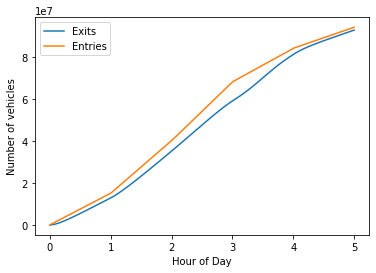

In [37]:
plt.plot(ts, np.cumsum(ns*vs), label="Exits")
plt.plot(ts, np.cumsum(demands)*L, label="Entries")
plt.legend()
plt.xlabel("Hour of Day")
plt.ylabel("Number of vehicles")

In [80]:
N0s = np.arange(0,3000,120)
PMTs = np.arange(0,30000,1200)
NFs = np.zeros((np.size(N0s), np.size(PMTs)))
L=5.
T = 1.

In [81]:
for i_n, N0 in enumerate(N0s):
    for i_p, PMT in enumerate(PMTs):
        NFs[i_n, i_p] = getN(PMT/ L, T, N0)
        #NFs.append(getN(PMT/ L, T, N0))
        #x.append(N0)
        #y.append(PMT)
        

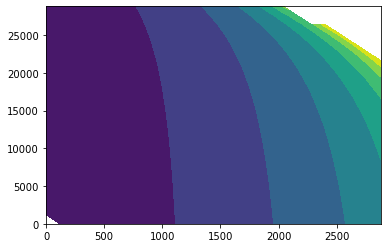

In [82]:
plt.contourf(N0s,PMTs,NFs)

([<matplotlib.axis.YTick at 0x7fb2b7fe8ee0>,
 [Text(0, 0, '0'),
  Text(0, 3, '3000'),
  Text(0, 6, '6000'),
  Text(0, 9, '9000'),
  Text(0, 12, '12000'),
  Text(0, 15, '15000'),
  Text(0, 18, '18000'),
  Text(0, 21, '21000'),
  Text(0, 24, '24000'),
  Text(0, 27, '27000')])

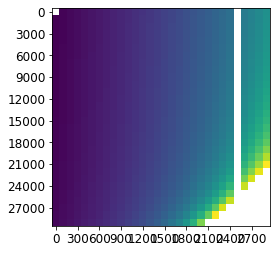

In [72]:
plt.imshow(NFs)
plt.xticks(range(0,len(N0s),3), N0s[::3], fontsize=12)
plt.yticks(range(0,len(PMTs),3), PMTs[::3], fontsize=12)


In [63]:
N0s[::2]

array([   0,  400,  800, 1200, 1600, 2000, 2400, 2800])

$V = \frac{4 \, {\left(A N - A N_{t}\right)} V \cosh\left(\frac{A V t}{L N}\right) + {\left(4 \, A^{2} + N^{2} - 2 \, N N_{t}\right)} V \sinh\left(\frac{A V t}{L N}\right)}{2 \, {\left(2 \, A N \cosh\left(\frac{A V t}{L N}\right) + {\left(N^{2} - 2 \, N N_{t}\right)} \sinh\left(\frac{A V t}{L N}\right)\right)}}$

Critical point is reached when

\\[
\sinh\left(\frac{A V t}{L N}\right) = -\frac{4 \, A {\left(N - N_{t}\right)} \cosh\left(\frac{A V t}{L N}\right)}{4 \, A^{2} + N^{2} - 2 \, N N_{t}}
\\]

$\frac{1}{2} \, N - \frac{\sqrt{N^{2} - \frac{4 \, L N \mathit{lam}}{V}} {\left({\left(N - 2 \, N_{t}\right)} \cosh\left(\frac{\sqrt{N^{2} - \frac{4 \, L N \mathit{lam}}{V}} V t}{2 \, L N}\right) + \sqrt{N^{2} - \frac{4 \, L N \mathit{lam}}{V}} \sinh\left(\frac{\sqrt{N^{2} - \frac{4 \, L N \mathit{lam}}{V}} V t}{2 \, L N}\right)\right)}}{2 \, {\left({\left(N - 2 \, N_{t}\right)} \sinh\left(\frac{\sqrt{N^{2} - \frac{4 \, L N \mathit{lam}}{V}} V t}{2 \, L N}\right) + \sqrt{N^{2} - \frac{4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{\sqrt{N^{2} - \frac{4 \, L N \mathit{lam}}{V}} V t}{2 \, L N}\right)\right)}}$

$\frac{N_{t} V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - {\left(N N_{t} V - 2 \, L N \mathit{lam}\right)} \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}{{\left(N - 2 \, N_{t}\right)} V \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) + V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}$

The average travvel time is 

\\[
\frac{L N \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) + {\left(L N^{2} - 2 \, L N N_{t}\right)} \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}{{\left(N - N_{t}\right)} V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - {\left(2 \, L N \mathit{lam} - {\left(N^{2} - N N_{t}\right)} V\right)} \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}
\\]

lam is

\\[
\frac{e^{\left(-\frac{2 \, L N N_{t} \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}{N^{2} V \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - N N_{t} V \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - 2 \, L N \mathit{lam} \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) + N V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - N_{t} V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}\right)}}{e^{\left(-\frac{L N^{2} \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}{N^{2} V \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - N N_{t} V \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - 2 \, L N \mathit{lam} \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) + N V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - N_{t} V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)} - \frac{L N \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}{N^{2} V \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - N N_{t} V \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - 2 \, L N \mathit{lam} \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) + N V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - N_{t} V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}\right)} + e^{\left(-\frac{2 \, L N N_{t} \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}{N^{2} V \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - N N_{t} V \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - 2 \, L N \mathit{lam} \sinh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) + N V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right) - N_{t} V \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}} \cosh\left(\frac{V t \sqrt{\frac{N^{2} V - 4 \, L N \mathit{lam}}{V}}}{2 \, L N}\right)}\right)}}
\\]

$\frac{L N_{0} \log\left(\frac{N_{0} V - 2 \, V N\left(t\right) + \sqrt{N_{0}^{2} V^{2} - 4 \, L N_{0} V \mathit{lam}}}{N_{0} V - 2 \, V N\left(t\right) - \sqrt{N_{0}^{2} V^{2} - 4 \, L N_{0} V \mathit{lam}}}\right)}{\sqrt{N_{0}^{2} V^{2} - 4 \, L N_{0} V \mathit{lam}}} = C + t$

$N\left(t\right) = \frac{N_{0} V {\left(e^{\left(\frac{\sqrt{N_{0}^{2} V^{2} - 4 \, L N_{0} V \mathit{lam}} C}{L N_{0}} + \frac{\sqrt{N_{0}^{2} V^{2} - 4 \, L N_{0} V \mathit{lam}} t}{L N_{0}}\right)} - 1\right)} - \sqrt{N_{0}^{2} V^{2} - 4 \, L N_{0} V \mathit{lam}} {\left(e^{\left(\frac{\sqrt{N_{0}^{2} V^{2} - 4 \, L N_{0} V \mathit{lam}} C}{L N_{0}} + \frac{\sqrt{N_{0}^{2} V^{2} - 4 \, L N_{0} V \mathit{lam}} t}{L N_{0}}\right)} + 1\right)}}{2 \, V {\left(e^{\left(\frac{\sqrt{N_{0}^{2} V^{2} - 4 \, L N_{0} V \mathit{lam}} C}{L N_{0}} + \frac{\sqrt{N_{0}^{2} V^{2} - 4 \, L N_{0} V \mathit{lam}} t}{L N_{0}}\right)} - 1\right)}}$


This is the equation with the choice term included: $N\left(t\right) = -\frac{{\left(L^{3} N_{0}^{2} \mathit{lam} e^{\left(\frac{B V}{L}\right)} - L^{2} N_{0}^{2} V e^{\left(\frac{2 \, B V}{L}\right)} - L^{2} N_{0} V e^{\left(\frac{2 \, B N_{0} V + B V N\left(t\right)}{L N_{0}}\right)} \log\left(L N_{0} \mathit{lam} - N_{0} V e^{\left(\frac{B V}{L}\right)} + V e^{\left(\frac{B V}{L} + \frac{B V N\left(t\right)}{L N_{0}}\right)}\right) + {\left(N_{0} V^{3} {\left(C + t\right)} e^{\left(\frac{2 \, B V}{L}\right)} - 2 \, {\left(C \mathit{lam} + \mathit{lam} t\right)} L N_{0} V^{2} e^{\left(\frac{B V}{L}\right)} + {\left(C \mathit{lam}^{2} + \mathit{lam}^{2} t\right)} L^{2} N_{0} V\right)} B e^{\left(\frac{B V N\left(t\right)}{L N_{0}}\right)}\right)} e^{\left(-\frac{2 \, B N_{0} V + B V N\left(t\right)}{L N_{0}}\right)}}{B L V^{2}}$

$N\left(t\right) = -\frac{L N_{0} C \mathit{lam}^{2} e^{\left(-\frac{2 \, B V}{L}\right)}}{V} - \frac{L N_{0} \mathit{lam}^{2} t e^{\left(-\frac{2 \, B V}{L}\right)}}{V} + 2 \, N_{0} C \mathit{lam} e^{\left(-\frac{B V}{L}\right)} + 2 \, N_{0} \mathit{lam} t e^{\left(-\frac{B V}{L}\right)} - \frac{L^{2} N_{0}^{2} \mathit{lam} e^{\left(-\frac{B V}{L} - \frac{B V N\left(t\right)}{L N_{0}}\right)}}{B V^{2}} - \frac{N_{0} V C}{L} - \frac{N_{0} V t}{L} + \frac{L N_{0}^{2} e^{\left(-\frac{B V N\left(t\right)}{L N_{0}}\right)}}{B V} + \frac{L N_{0} \log\left(L N_{0} \mathit{lam} - N_{0} V e^{\left(\frac{B V}{L}\right)} + V e^{\left(\frac{B V}{L} + \frac{B V N\left(t\right)}{L N_{0}}\right)}\right)}{B V}$

$N\left(t\right) = -\frac{{\left(L^{3} N_{0}^{2} l e^{\left(\frac{B V}{L}\right)} - L^{2} N_{0}^{2} V e^{\left(\frac{2 \, B V}{L}\right)} - L^{2} N_{0} V e^{\left(\frac{2 \, B N_{0} V + B V N\left(t\right)}{L N_{0}}\right)} \log\left(L N_{0} l - N_{0} V e^{\left(\frac{B V}{L}\right)} + V e^{\left(\frac{B V}{L} + \frac{B V N\left(t\right)}{L N_{0}}\right)}\right) + {\left(N_{0} V^{3} {\left(C + t\right)} e^{\left(\frac{2 \, B V}{L}\right)} - 2 \, {\left(C l + l t\right)} L N_{0} V^{2} e^{\left(\frac{B V}{L}\right)} + {\left(C l^{2} + l^{2} t\right)} L^{2} N_{0} V\right)} B e^{\left(\frac{B V N\left(t\right)}{L N_{0}}\right)}\right)} e^{\left(-\frac{2 \, B N_{0} V + B V N\left(t\right)}{L N_{0}}\right)}}{B L V^{2}}$

## Multiple Regions


The differential equation can be solved numerically (see http://educ.jmu.edu/~sochacjs/M341/TheQuadraticODE.pdf). Starting again with the differential equation governing accumulation over time:

\\[v(t) = V_0 \left(1 - \frac{N(t)}{N_0} \right) = V_0 -  \frac{V_0 n_1(t)}{N_0}\\]

\\[\frac{d n_1(t)}{dt} = \lambda_1 - \frac{n_1 V_0}{L_1} + \frac{V_0 n_1^2(t)}{N_0 L_1} + \frac{n_2 V_0 X_{12}}{L_2} - \frac{V_0 n_2^2(t)}{N_0 L_2} X_{12}  \\
\frac{d n_2(t)}{dt} = \lambda_2 - \frac{n_2 V_0}{L_2} + \frac{V_0 n_2^2(t)}{N_0 L_2} + \frac{n_1 V_0 X_{21}}{L_1} - \frac{V_0 n_1^2(t)}{N_0 L_1} X_{21}\\]

\\[ \frac{d n_1(t)}{dt} = \lambda - \frac{ V_0 n_1(t)}{L} + \frac{n_1^2(t) V_0}{N_0 L}\\]

This equation can be factored:

\\[\frac{d N(t)}{dt} = \frac{V_0}{N_0 L}\left(N - \frac{N_0}{2} -  \sqrt{\frac{N_0^2}{4} - \frac{N_0 L_0 \lambda}{V_0}} \right) \left(N - \frac{N_0}{2} + \sqrt{\frac{N_0^2}{4} - \frac{N_0 L_0 \lambda}{V_0}} \right)\\]

If we define $A = \sqrt{\frac{N_0^2}{4} - \frac{N_0 L_0 \lambda}{V_0} }$ , we can rewrite the differential equation as

\\[\frac{d N(t)}{dt} = \frac{V_0}{N_0 L} \left( {N} - \frac{N_0}{2} - A \right)\left({N} - \frac{N_0}{2} + A \right).
\\]


\\[\frac{dn_k(t)}{dt} = \lambda_k + V_0 \left( \frac{n_k^2(t)}{N_0 L_k} - \frac{n_k(t)}{L_k} + \sum \limits_{j \ne k} X_{kj} \left(\frac{n_j}{L_j} - \frac{n_j^2(t)}{N_0 L_j}\right)\right) \\
\frac{dn_k(t)}{dt} = \lambda_k + V_0 \left(\sum \limits_{j = 1}^{K} \frac{X_{kj}}{L_j} \left(n_j(t) - \frac{n_j^2(t)}{N_0}\right)\right) \\]

\\[s N_k(s) -n_k(0) = \frac{\lambda_k}{s} + \sum \limits_{j=1}^{k}\frac{V_0 X_{kj}}{L_j} \left(N_j(s) - \frac{2}{N_0 s^3} \right)\\]

\\[\sum \limits_{j=1}^{k} \left( \delta_{kj} s - \frac{V_0 X_{kj}}{L_j} \right) N_k(s) = n_k(0) + \frac{\lambda_k}{s} - \sum \limits_{j=1}^{k}\frac{V_0 X_{kj}}{L_j} \left(\frac{2}{N_0 s^3} \right)\\]